# Torch란?
torch는 tensorflow랑 비슷하게 딥러닝을 쉽게 구축 할 수 있게 해주는 라이브러리입니다.

초기 Tensorflow의 초창기 버전 보다 훨씬 구축하기 쉽게 만들어져 있어 초기 인공지능을 공부하시던 분들이 애용하시던 라이브러리입니다. 또한 딥러닝에 있어서 많은 부분을 직접 다룰 수 있어서 최근 논문에서 구현된 코드는 대부분 Torch로 구현되서 나오는 경향이 있습니다. Keras보다 상대적으로 구축하기 까다롭지만 배워놓으시면 많은 부분에서 좋은 점이 있습니다.

# 로컬 설치 방법


https://pytorch.org/get-started/locally/

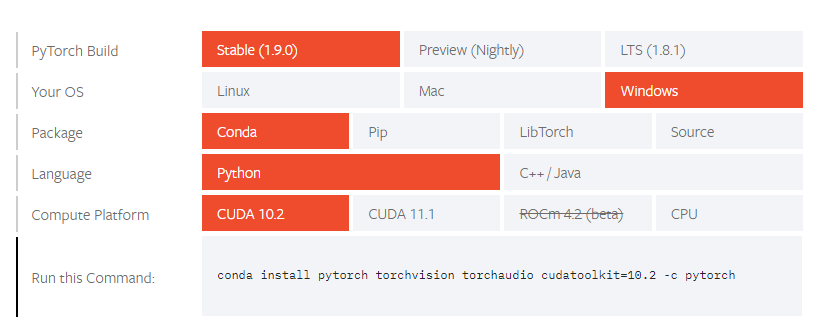

위의 링크에 들어가서 자신이 구축하고 싶은 환경을 선택하고 위에 Run this Command를 anaconda면 cmd에서 "conda activate [가상환경 이름]" 을 하고 이후에 실행하면 됩니다.

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# DATASETS & DATALOADERS

데이터는 많은 부분에 있어 전처리가 필요하거나 이미지 파일의 경우 모든 사진을 RAM등에 올리지 못하고 필요할 때마다 저장장치에 올려서 학습시킬 필요가 많이 생깁니다. 이런 경우 이러한 코드를 매번 Main함수에 덕지덕지 붙이는 것보다 Module화를 시켜 필요할 때마다 import를 시킬 수 있습니다. 그렇기 때문에 Dataset을 만들어서 관리하게 됩니다.

다음 데이터 셋은 코랩에 기본적으로 있는 mnist_train_small.csv를 사용할 것이기 때문에 이 파일을 코랩에서 실행시켜주시길 바랍니다.



# 데이터 불러오기

In [2]:
df_train = pd.read_csv('./sample_data/mnist_train_small.csv', header=None)
df_test = pd.read_csv('./sample_data/mnist_test.csv', header=None)

train_labels = df_train.iloc[:, 0]
train_images = df_train.iloc[:, 1:]
test_labels = df_test.iloc[:, 0]
test_images = df_test.iloc[:, 1:]

데이터를 한번 살펴보겠습니다.

In [3]:
train_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 784 entries, 1 to 784
dtypes: int64(784)
memory usage: 119.6 MB


데이터는 총 2만개, 한 데이터당 column이 784개로 이루어 진 것을 볼 수 있습니다.

상황 1. 나는 이 이미지를 CNN으로 사용하고 싶다! 그래서 1차원 벡터를 2차원 행렬로 바꿔주고 싶다!

파이썬 개념!!

저기 __init__에서 __은 왜 붙는걸까?

두가지 정도로 해석 할 수 있다.

1. 메소드 네이밍


이는 클래스 별로 메소드들이 충돌되지 않게 하기 위해서 사용하는 경우를 의미한다. 예를 들어

강아지 클래스에 귀엽다는 메소드가 있고 고양이라는 클래스에도 귀엽다는 메소드가 있다고 가정을 해보자.

우리가 우리 코드를 컴파일 할때 우리는 스택에 코드에 있는 클래스나 함수를 차곡차곡 쌓게 된다. 이때 두 귀엽다라는 메소드는 어떻게 구별될 것이냐 라는게 문제다. 메소드 이름만을 가지고 해당 메소드를 저장하기에는 힘들어진다.
따라서 __를 붙이게 되면 컴파일 후 메소드는 

_강아지_귀엽다 로 바뀌게 된다. 즉, __사이에 클래스 이름이 들어가서 메소드 간의 구별을 용이하게 해준다는 것이다.


2. 특정한 함수

__init__이나 __len__등은 특정한 목적을 가지는 메소드로 우리가 굳이 메소드를 call하지 않아도 __init__은 클래스를 정의할때 (ex, a = 강이지()) 바로 실행되는 친구이고 __len__은 클래스에 길이를 사용자가 물었을 때 해당 메소드 내에 있는 return값이 클래스의 길이로 지정이 된다.

In [4]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None):
        self.X = images
        self.y = labels

         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):

        data = self.X.iloc[i, :]
        data = np.asarray(data).astype(np.float32).reshape(28, 28, 1)
        
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

여기서 MNISTDataset(Dataset)에서 Dataset이 들어가는 이유는 내가 Dataset이라는 클래스를 상속 받게 다는 것입니다.

In [5]:
train_data = MNISTDataset(train_images, train_labels)
test_data = MNISTDataset(test_images, test_labels)

이렇게 만들어진 Dataset 클래스는 데이터셋의 feature를 가져오고 하나의 샘플에 정답지인 y를 mapping시켜주는 역할을 한다. 또한 미니배치를 전달하고 에폭마다 데이터를 섞는등의 역할도 수행합니다

우리는 이제 여기서 이 데이터셋을 반복할 수 있는 객체로 만들어 모델에게 계속 데이터를 공급시켜주게 loader를 만들게 됩니다. 이 loader의 경우 dataset의 __getitem__메소드를 인덱스와 함께 제공을 함으로써 데이터셋에서 자동적으로 데이터를 뱉게 해주는 역할을 합니다.

In [6]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last = True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True, drop_last = True)

코드에서도 알 수 있다 싶이 dataloader를 통해 배치의 크기와 shuffle의 유무 등을 조절 할 수 있다. 또한 배치로 묶게 되면 마지막에 배치보다 갯수가 적은 데이터들이 남게 되는 이때 이들을 그대로 사용할지 말지 결정하게 됩니다.

이제 우리가 만든 train_loader는 iterative객체가 되고 이에 따라 for문등에 변수로 쓰일 수 있게 되었다.

In [7]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 28, 28, 1])
torch.Size([64])


# Quiz 1
데이터가 정규화된 데이터를 출력받고 싶다. 현재 trainloader가 뱉는 데이터는 정규화가 안되어 있다. 픽셀의 최댓값인 255을 나누어주어서 데이터를 0과 1사이로 만들어보세요.

In [8]:
class Normalized_MNISTDataset(Dataset):
    def __init__(self, images, labels):

         
    def __len__(self):
    

    def __getitem__(self, i):

        

In [9]:
train_data = MNISTDataset(train_images, train_labels)
norm_train_data = Normalized_MNISTDataset(train_images, train_labels)

In [10]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
norm_train_loader = DataLoader(norm_train_data, batch_size=64, shuffle=True)

In [11]:
for (x, y), (norm_x, y) in zip(train_loader, norm_train_loader):
    fig = plt.figure(figsize = (10, 10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.plot(x[0].reshape(-1,))
    ax2.plot(norm_x[0].reshape(-1,))
    ax1.set_title('Before')
    ax2.set_title('After')
    break

# 모델 만들어보기

Torch는 텐서플로우와 달리 내가 사용할 device를 설정해줘야합니다. 즉, 내가 GPU로 연산을 할 것인지 CPU로 연산을 할 것인지 설정해줘야합니다.

다소 귀찮아 보일 수 있지만 실제로 Tensorflow를 서버에서 사용하다 보면 드라이버에 따라 Tensorflow가 gpu를 찾을 수도 있고 없을 수도 있습니다. (3000번대 nvdia gpu들이 특히 요 부분을 짜증나게 합니다.) 그래서 torch로 코드를 짜면 확실하게 내가 gpu를 사용하는 걸 알 수 있어 오히려 많은 부분에서 시간을 아낄 수 있습니다. 

일단은 여기서는 CPU를 가지고 연산을 진행해보겠습니다. 주석 처리된 부분은 없애고 밑에 부분을 주석처리하면 실행하다 오류가 발생할겁니다. 이유는 뒤에 설명드리겠습니다.

In [12]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [13]:
from torch import nn

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 이번에는 CNN을 쓰지 않을 거기 때문에 들어온 input을 1차원 벡터로 펼친다.
        self.flatten = nn.Flatten()
        # Tensorflow에서 Sequential처럼 다음의 layer들을 거쳐서 가게 된다.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
        #위에꺼는 사실상 내가 어떤 레이어를 쓸 것이다를 선언한 부분이고 이 부분이 input이 들어오면 어떻게 flow시킬 것인가를 정의하는 부분이다.
        # 우리의 클래스는 NeuralNetwork를 상속받았기 때문에 이러한 forward드는 추후에 NeuralNetwork(input)을 실행시키면 forward가 실행이된다.
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [15]:
#이제 우리는 우리가 만든 클래스를 어떠한 디바이스에서 실행시킬지 선언해줘야한다.
model = NeuralNetwork().to(device)
#모델을 출력해보자.
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


 저번 과제에서도 알 수 있다 싶이 여기까지는 우리가 계산 그래프를 어떻게 만들 것인가 어떤 device를 통해 계산을 진행 시킬 것이고 어떻게 순전파를 시킬것인가를 명시해주는 단계였습니다. 이제 우리는 이 모델을 학습 시켜야 합니다. 이번 시간은 단순히 Pytorch와 친해지는 시간을 위한 것이니 auto grad를 사용하지는 않을 것입니다.

# 하이퍼 파라미터 설정과 최적화 루프

In [16]:
# 전역변수는 주로 대문자로 씁니다.
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 5

우리는 분류를 진행 할 것이기 때문에 손실함수의 경우 Cross entropy로 진행 할 것입니다. optimizer 같은 경우 단순한 SGD를 사용하겠습니다.

In [17]:
loss_fn = nn.CrossEntropyLoss()
# 텐서플로우랑 다르게 torch에서는 optimizer에게 내가 어떤 모델의 변수를 최적화 해줄 것인지 명시해줘야합니다. 즉 학습 대상을 명시해줘야한다는 것이죠. 
# 그렇기 때문에 SGD를 선언할때 model.parameters를 통해 내가 어떤 파라미터를 최적화 할것인지 명시해줘야합니다.
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        #먼저 모델 매개변수의 변화도를 재설정 해줘야합니다. 변화도는 학습 시 더해져서 계산 되기 때문에
        # 이전 학습과 명시적으로 구분되게 하기 위해 0으로 설정해 주는 부분입니다.
        optimizer.zero_grad()
        # 우리가 구한 손실값을 역전파 시키는 부분입니다. 이렇게 되면 optimizer는 각 파라미터 별 손실의 변화도를 저장하게 됩니다.
        loss.backward()
        # 변화도가 계산 되어 있기 때문에 이 파라미터와 연결된 optimizer를 실행 시키면 수집된 변화도를 바탕으로 매개변수를 조정하게 됩니다.
        optimizer.step()
        #학습 시 어떻게 학습이 되고 있는 지를 말해주는 부분입니다.
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Keras의 경우 Test에 대한 검사가 fit에서 구현되어 있지만 Pytorch에서는 test code까지 구축해줘야합니다.
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [19]:
def main():
    for t in range(EPOCHS):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer)
        test_loop(test_loader, model, loss_fn)
    print("Done!")

In [20]:
if __name__ == "__main__":
    main()

Epoch 1
-------------------------------
loss: 9.082942  [    0/20000]
loss: 1.795643  [ 6400/20000]
loss: 1.748877  [12800/20000]
loss: 1.667753  [19200/20000]
Test Error: 
 Accuracy: 29.7%, Avg loss: 1.693174 

Epoch 2
-------------------------------
loss: 1.900842  [    0/20000]
loss: 1.643090  [ 6400/20000]
loss: 1.573332  [12800/20000]
loss: 1.845827  [19200/20000]
Test Error: 
 Accuracy: 30.4%, Avg loss: 1.659176 

Epoch 3
-------------------------------
loss: 1.697313  [    0/20000]
loss: 1.486866  [ 6400/20000]
loss: 1.628468  [12800/20000]
loss: 1.712174  [19200/20000]
Test Error: 
 Accuracy: 30.3%, Avg loss: 1.645643 

Epoch 4
-------------------------------
loss: 1.655748  [    0/20000]
loss: 1.553619  [ 6400/20000]
loss: 1.621666  [12800/20000]
loss: 1.572273  [19200/20000]
Test Error: 
 Accuracy: 30.2%, Avg loss: 1.647420 

Epoch 5
-------------------------------
loss: 1.768289  [    0/20000]
loss: 1.603721  [ 6400/20000]
loss: 1.548067  [12800/20000]
loss: 1.780576  [19200

# 모델 저장 및 복구
이제 우리는 모델을 학습을 했고 해당 모델을 저장하는 법을 배워보겠습니다. 이번에는 모델의 형태를 포함하여 저장하고 불러오는 법만 배우도록 하겠습니다.

In [21]:
torch.save(model, 'saved_model.pth')

In [22]:
!ls

sample_data  saved_model.pth


In [23]:
loaded_model = torch.load('saved_model.pth')

In [24]:
test_loop(test_loader, loaded_model, loss_fn)

Test Error: 
 Accuracy: 30.4%, Avg loss: 1.646436 



# GPU사용해보기

위에 gpu관련되서 주석된 부분을 없애고 실행해보시면 main함수를 실행하는과정에서 이런 오류가 발생할것입니다. 즉, 모든 계산을 어떤거를 가지고 할 것인가에 따라서 모든 텐서가 CPU의 메모리에 들어가 있거나 GPU의 메모리에 들어가 있어야 하는데 그렇기 않기 때문에 발생하는 오류입니다. 이를 해결하기 위해서 우리는 dataset부분을 조금 수정해보도록 하겠습니다.

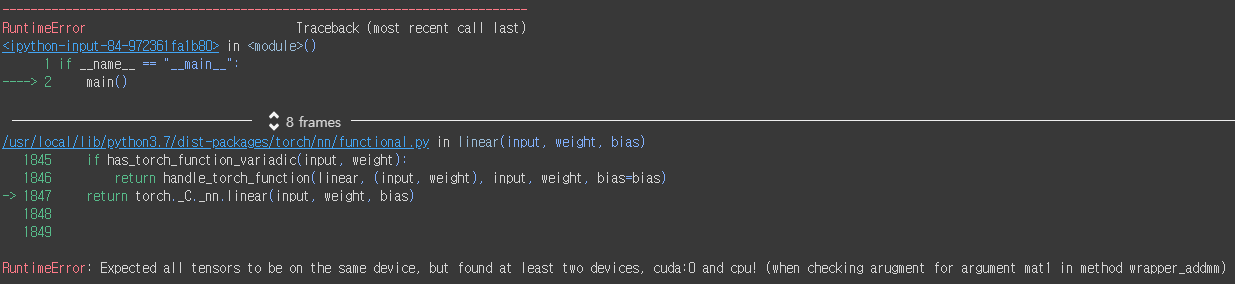

# 코랩에서 gpu설정 방법

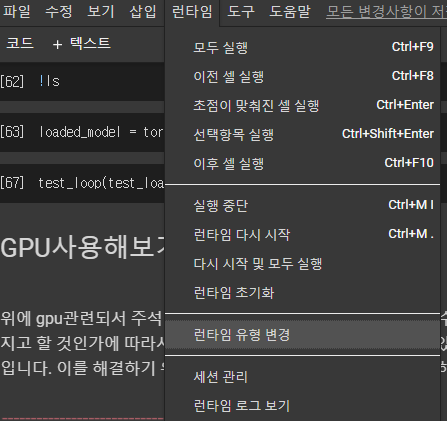

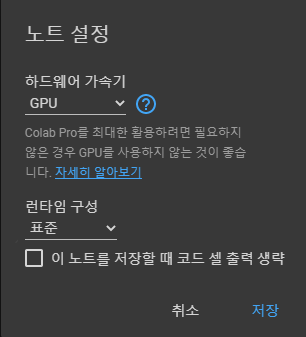

In [41]:
LEARNING_RATE = 1e-5
# gpu를 사용할 때 아까와 같은 Learning_rate는 너무커서 학습이 안되더라구요... 난 또 내가 코딩 잘 못한 줄 알고 1시간 반동안 삽질했네요..ㅋㅋㅋㅋㅋㅋㅋㅋㅋ
# 사실 이 모델의 경우 모델이 얕아서 cpu나 gpu나 별 차이가 없긴 합니다. 그래도 나중에 쓰면 확실히 빨라집니다.

In [42]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda:0 device


In [43]:
gpu_model = NeuralNetwork().to(device)
gpu_loss_fn = nn.CrossEntropyLoss().to(device)
gpu_optimizer = torch.optim.Adam(gpu_model.parameters(), lr=LEARNING_RATE)

In [44]:
import torchvision.transforms as transforms

In [45]:
# 그 전의 사용한 dataset은 numpy를 반환하기 때문에 tensor로 반환하는 부분을 추가하기위해 사용되는 method입니다. 나중에 관련해서 더 설명 드리죠.
transform = transforms.Compose(
    [
     transforms.ToTensor(),
])

In [46]:
class GPUMNISTDataset(Dataset):
    def __init__(self, images, labels, transforms):
        self.X = images
        self.y = labels
        self.device = device
        self.transforms = transforms

         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):

        data = self.X.iloc[i, :]
        data = np.asarray(data).astype(np.float32).reshape(28, 28, 1)
        data = self.transforms(data)
        label = torch.from_numpy(np.asarray(self.y[i]).astype(np.long))
        return data, label 

In [47]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Keras의 경우 Test에 대한 검사가 fit에서 구현되어 있지만 Pytorch에서는 test code까지 구축해줘야합니다.
def test_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [48]:
train_data = GPUMNISTDataset(train_images, train_labels, transform)
test_data = GPUMNISTDataset(test_images, test_labels, transform)

In [49]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last = True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True, drop_last = True)

In [50]:
def gpu_train():
    for t in range(EPOCHS):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, gpu_model, gpu_loss_fn, gpu_optimizer, device)
        test_loop(test_loader, gpu_model, gpu_loss_fn, device)
    print("Done!")

In [51]:
if __name__ == "__main__":
    gpu_train()

Epoch 1
-------------------------------
loss: 11.064548  [    0/20000]
loss: 2.375949  [ 6400/20000]
loss: 2.218723  [12800/20000]
loss: 2.071773  [19200/20000]
Test Error: 
 Accuracy: 22.6%, Avg loss: 1.988364 

Epoch 2
-------------------------------
loss: 2.007618  [    0/20000]
loss: 2.045761  [ 6400/20000]
loss: 1.557502  [12800/20000]
loss: 1.451004  [19200/20000]
Test Error: 
 Accuracy: 49.0%, Avg loss: 1.426859 

Epoch 3
-------------------------------
loss: 1.671172  [    0/20000]
loss: 1.252688  [ 6400/20000]
loss: 1.125376  [12800/20000]
loss: 1.251200  [19200/20000]
Test Error: 
 Accuracy: 58.0%, Avg loss: 1.157390 

Epoch 4
-------------------------------
loss: 1.190460  [    0/20000]
loss: 1.124747  [ 6400/20000]
loss: 0.863078  [12800/20000]
loss: 1.307213  [19200/20000]
Test Error: 
 Accuracy: 67.6%, Avg loss: 0.915602 

Epoch 5
-------------------------------
loss: 1.041256  [    0/20000]
loss: 0.634603  [ 6400/20000]
loss: 0.663276  [12800/20000]
loss: 0.547279  [1920

# Quiz 2
직접 만들어보는 dataloader와 모델

fashion mnist를 활용하여 데이터셋과 로더를 만들어보고 모델을 만들어 학습시켜보세요. 데이터셋은 input을 정규화시켜야합니다. 또한 모델은

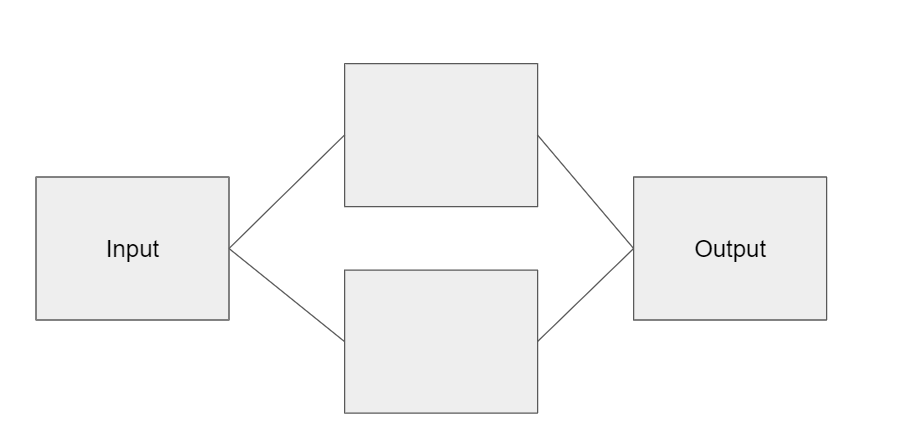

다음과 같이 중간에 flow가 갈라졌다가 합쳐지게 만들어보세요.

마지막에 모델 저장해보고 불러오기도 해보세요. 화이팅

In [59]:
'''
code
'''
#화이팅

'\ncode\n'